# shapes and densities

Original image:


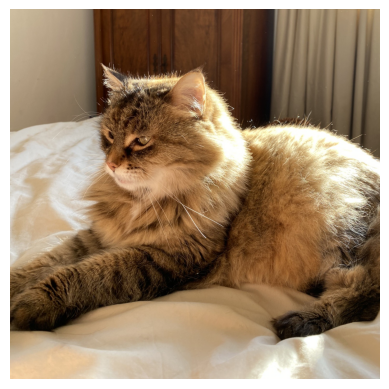

Combination 1/4: {'mask': 'circle', 'opacity': 140}


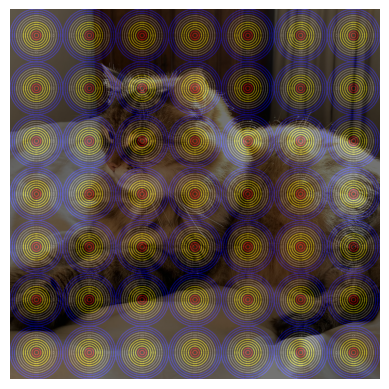

Combination 2/4: {'mask': 'square', 'opacity': 140}


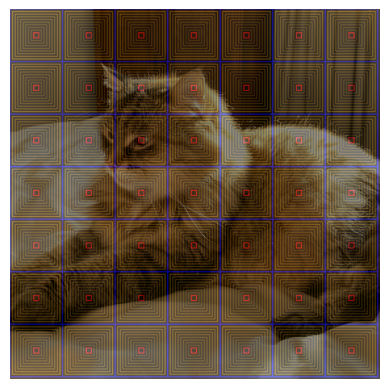

Combination 3/4: {'mask': 'diamond', 'opacity': 140}


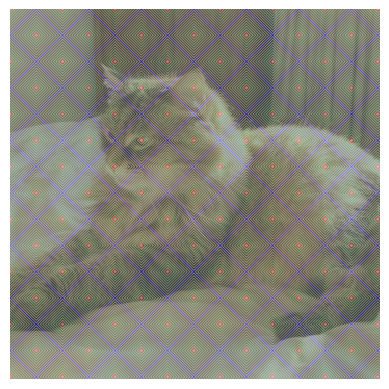

Combination 4/4: {'mask': 'knit', 'opacity': 140}


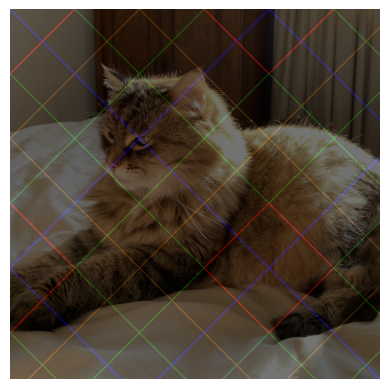

In [10]:
from advx.masks import get_circle_mask, get_square_mask, get_diamond_mask, get_knit_mask
from advx.utils import add_overlay
import matplotlib.pyplot as plt
import itertools
from PIL import Image
import requests
import time

COMBINATIONS = {
    "mask": ["circle", "square", "diamond", "knit"], # "word" is hard to interpret
    # "opacity": [50, 80, 110, 140, 170],  # 0;255 - best based on previous experiments
    "opacity": [140],  # 0;255 - best based on previous experiments
}

def get_advx(img: Image.Image, combination: dict) -> Image.Image:
    density = 70 # best based on previous experiments
    if combination["mask"] == "diamond":
        density = int(density / 10)  # 1 -> 10 (count per row)
        return add_overlay(img, get_diamond_mask(diamonds_per_row=density), opacity=combination["opacity"])

    elif combination["mask"] == "circle":
        density = int(density / 10)  # 1 -> 10 (count per row)
        img = add_overlay(img, get_circle_mask(row_count=density), opacity=combination["opacity"])

    elif combination["mask"] == "square":
        density = int(density / 10)  # 1 -> 10 (count per row)
        img = add_overlay(img, get_square_mask(row_count=density), opacity=combination["opacity"])

    elif combination["mask"] == "knit":
        density = int(density * 10)  # 100 -> 1000 (iterations)
        img = add_overlay(img, get_knit_mask(step=density), opacity=combination["opacity"])
    img = img.convert("RGB")
    return img


url = "https://sueszli.github.io/datasets/cat_1966.jpeg"
img = Image.open(requests.get(url, stream=True).raw).convert("RGBA")
img = img.crop((0, img.height - img.width, img.width, img.height))

print(f"Original image:")
plt.imshow(img)
plt.axis("off")
plt.show()

time.sleep(1)

random_combinations = list(itertools.product(*COMBINATIONS.values()))
num_combinations = len(random_combinations)

for i, comb in enumerate(random_combinations):
    print(f"Combination {i+1}/{num_combinations}: {dict(zip(COMBINATIONS.keys(), comb))}")
    advx_img = get_advx(img.copy(), dict(zip(COMBINATIONS.keys(), comb)))
    plt.imshow(advx_img)
    plt.axis("off")
    plt.show()


# hcaptcha style distortions

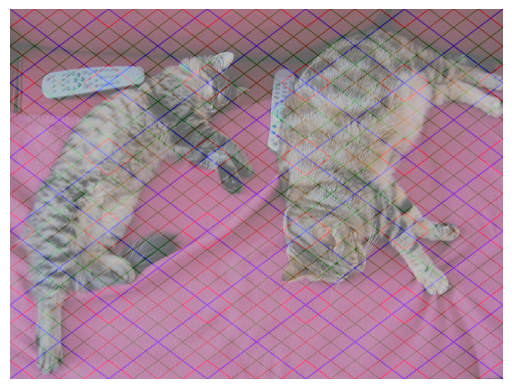

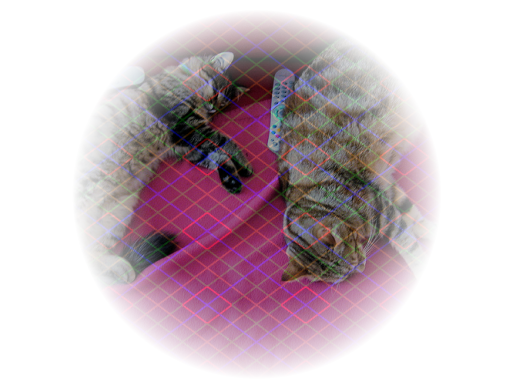

(1000, 700)


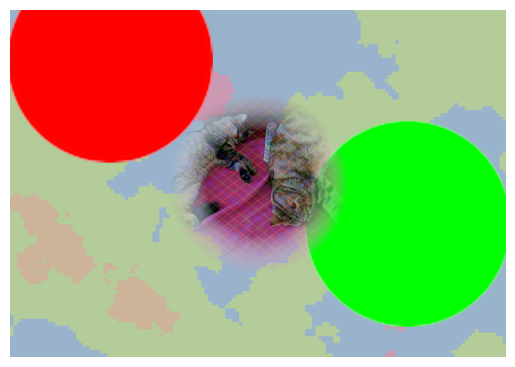

In [2]:
from advx.background import get_perlin_background
from advx.utils import get_rounded_corners, place_within, add_overlay
from advx.masks import get_diamond_mask, get_knit_mask
import matplotlib.pyplot as plt
from PIL import Image
import requests

background: Image.Image = get_perlin_background()


url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw).convert("RGBA")
opcacity = 100
# knit	192	1
img = add_overlay(img, get_knit_mask(step=200), opacity=opcacity)
plt.imshow(img)
plt.axis('off')
plt.show()

inner1: Image.Image = get_rounded_corners(Image.new("RGBA", (100, 100), (255, 0, 0, 255)))
inner2: Image.Image = get_rounded_corners(Image.new("RGBA", (100, 100), (0, 255, 0, 255)))
inner3: Image.Image = get_rounded_corners(img, fraction=0.29)

plt.imshow(inner3)
plt.axis('off')
plt.show()

print(background.size)
center_x = background.size[0] // 2
center_y = background.size[1] // 2

result = place_within(background, inner1, inner_position=(200, 100))
result = place_within(result, inner2, inner_position=(center_x + 300, center_y + 80))
result = place_within(result, inner3, inner_position=(center_x, center_y))
plt.imshow(result)
plt.axis('off')
plt.show()

# chaining models

Generating an image...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

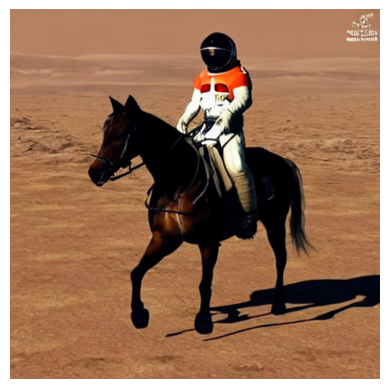

Captioning the image...


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


text_queries: ['a person', 'a horse', 'a dirt field']
Classifying the image...


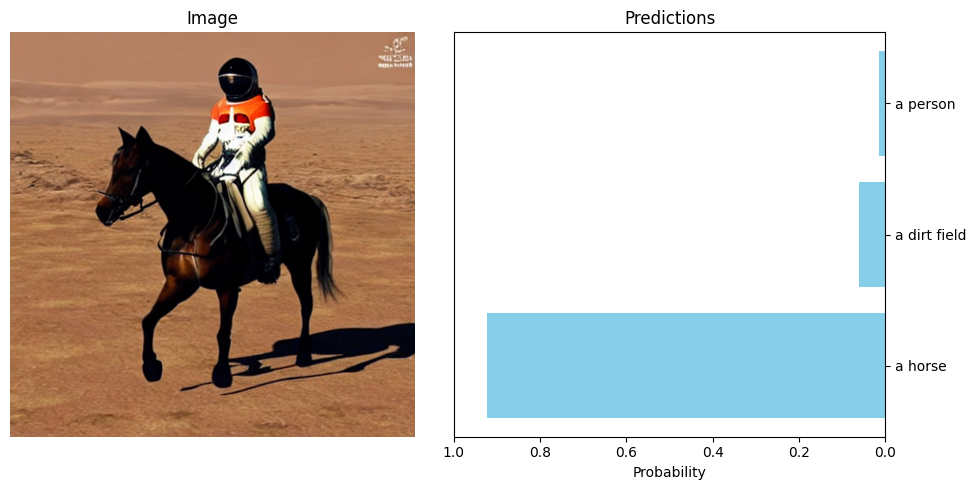

Detecting objects in the image...
Segmenting objects in the image...


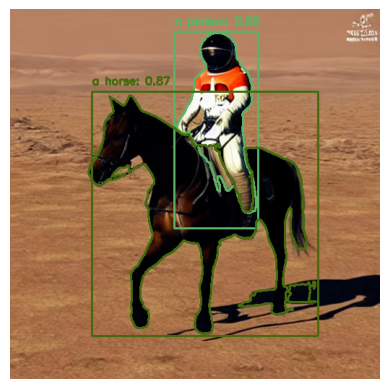

In [ ]:
from matplotlib import pyplot as plt
from utils import set_seed
from models.generation import gen_stable_diffusion
from models.cls import classify_clip, plot_classification
from models.det import detect_vit
from models.seg import segment_sam1, plot_segmentation_detection
from models.caption import caption_gpt2


set_seed(42)

GREEN = "\033[92m"
RESET = "\033[0m"

# 1. generate an image
print(f"{GREEN}Generating an image...{RESET}")
img = gen_stable_diffusion("an austronaut on mars riding a horse")
plt.imshow(img)
plt.axis('off')
plt.show()

# 2. caption it
print(f"{GREEN}Captioning the image...{RESET}")
text_queries = caption_gpt2(img)
print("text_queries:", text_queries)

# 3. classify, detect, segment it
print(f"{GREEN}Classifying the image...{RESET}")
probs = classify_clip(img, text_queries)
plot_classification(img, text_queries, probs)

print(f"{GREEN}Detecting objects in the image...{RESET}")
threshold = 0.1
boxes, scores, labels = detect_vit(img, text_queries, threshold)

print(f"{GREEN}Segmenting objects in the image...{RESET}")
masks = segment_sam1(img, boxes)
plot_segmentation_detection(img, boxes, scores, text_queries, masks)
